# FIT5196 Assessment 2 

Date: 18/05/2019

Version: 1.0

Environment: Python 3.6.5 and Anaconda 4.4.10 (64-bit)

Libraries used:
* pandas
* matplotlib
* Kmeans
* math
* KNeighborsClassifier
* parse
* time
* datetime
* r2_score


## 0. Assumption
Following input files are in the current directory:
* `29620163_dirty_data.csv`
* `29620163_missing_value.csv`
* `29620163_outliers.csv`
* `edges.csv`
* `nodes.csv`



## 1. Introduction
The dataset is about Uber Ridesharing data in Victoria, Australia. 

This task at hand is to do graphica and non-graphical EDA on the data and perform the following task:

1. Detect and fix errors in `29620163_dirty_data.csv` .
2. Detect and remove outliers in `29620163_outliers.csv` .
3. Impute the missing values in `29620163_missing_value.csv`.


More details for each task will be given in the following sections.

## 2. Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx
from dateutil.parser import parse
import time
import datetime
from sklearn.metrics import r2_score

## 3.Dirty data

Read the data from the dirty file and examine its size and first few rows.

In [2]:
df_dirty = pd.read_csv('29620163_dirty_data.csv')
print(df_dirty.shape)
df_dirty.head()

(296, 14)


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15149.5,2018-02-11,07:42:29,4917.48,9:04:26,12.99
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50805.0,2018-06-21,05:17:26,13173.36,8:56:59,23.34
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43998.7,2018-06-22,08:52:10,10677.60,11:50:07,54.64
4,ID5319568239,2,7,1,-37.861835,144.905716,-37.813678,144.939437,10194.1,2018-02-19,08:50:24,3359.88,9:46:23,217.54


First have a look at the data types of the columns. 

In [3]:
df_dirty.dtypes

Unnamed: 0                object
Uber Type                  int64
Origin Region              int64
Destination Region         int64
Origin Latitude          float64
Origin Longitude         float64
Destination Latitude     float64
Destination Longitude    float64
Journey Distance(m)      float64
Departure Date            object
Departure Time            object
Travel Time(s)           float64
Arrival Time              object
Fare$                    float64
dtype: object

The below describe command shows some basic stats about all the numerical columns. 

We see that here that the count of all columns is 296, that means there are no missing values. 

In [4]:
df_dirty.describe()

,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,0.675676,5.179054,4.817568,-36.570127,144.932444,-36.568380,144.935503,16106.954392,4168.793041,54.527872
std,0.743024,2.569383,2.628494,9.776934,0.111982,9.768541,0.102451,16743.550281,4031.566947,125.187913
min,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,1159.000000,283.920000,2.340000
25%,0.000000,3.000000,2.000000,-37.823152,144.927068,-37.823993,144.927542,5338.250000,1353.825000,11.355000
50%,1.000000,5.000000,5.000000,-37.814757,144.973135,-37.814940,144.954353,8543.000000,2438.220000,17.865000
75%,1.000000,8.000000,7.000000,-37.804930,144.991467,-37.806308,144.992435,12731.500000,4050.740000,29.997500
max,3.000000,9.000000,9.000000,38.110916,145.046450,37.861835,145.046450,51061.000000,13216.980000,799.580000


### 3.1 Fix Uber Type

We start with fixing the uber type first. 


In [5]:
df_dirty['Uber Type'].value_counts()

0    143
1    108
2     43
3      2
Name: Uber Type, dtype: int64

We see above that there is an extra Uber type '3', which shouldn't be there and possible anamolies in other data points too.

A pattern is observed in the Ride ID and the Uber type:

If the ID starts with 'ID1', then the uber type is '0'.

If the ID starts with 'ID3', then the uber type is '1'.

If the ID starts with 'ID5', then the uber type is '2'.

In [6]:
# The below function gives the Uber type given the initial string of the Ride ID.
def get_uber_type(id_val):
    if(id_val == "ID1"):
        return 0
    elif(id_val == "ID3"):
        return 1
    elif(id_val == "ID5"):
        return 2

In [7]:
# Create another column with the first 3 characters of Ride ID. 
df_dirty['id_slice'] = df_dirty['Unnamed: 0'].str.slice(0,3)
df_dirty['id_slice'].head()

0    ID1
1    ID1
2    ID1
3    ID3
4    ID5
Name: id_slice, dtype: object

In [8]:
#Create another column with the correct Uber Type ID using the function created above
df_dirty['utype_slice'] = df_dirty['id_slice'].apply(lambda x: get_uber_type(x))
df_dirty['utype_slice'].value_counts()

0    148
1    108
2     40
Name: utype_slice, dtype: int64

Below we see that there are a few rows which do not have correct Uber type.

In [9]:
df_dirty[df_dirty['Uber Type'] != df_dirty['utype_slice']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,id_slice,utype_slice
125,ID5339069256,1,1,6,-37.806217,144.941498,-37.773803,144.983647,9370.0,2018-06-15,21:28:19,2899.26,22:16:38,207.29,ID5,2
126,ID5950644890,1,2,1,-37.812962,144.931495,-37.801571,144.963125,4371.0,2018-02-06,16:14:06,1172.10,16:33:38,94.86,ID5,2
132,ID1179899382,3,3,4,-37.819390,144.981888,-37.813991,145.007279,2916.0,2018-03-24,11:24:03,723.06,11:36:06,8.76,ID1,0
133,ID1924565490,2,9,2,-38.110916,144.654173,-37.814270,144.935746,42838.0,2018-02-06,03:02:47,10292.40,5:54:19,19.39,ID1,0
134,ID1968442692,2,1,7,-37.825146,144.961155,-37.861835,144.905716,7899.0,2018-05-24,14:27:45,2745.00,15:13:30,9.96,ID1,0
136,ID1510953941,2,3,1,-37.814558,144.994023,-37.800993,144.972261,3143.0,2018-03-27,04:49:09,826.68,5:02:55,11.79,ID1,0
140,ID3210349258,2,6,2,-37.790797,144.985865,-37.811322,144.936930,6109.0,2018-04-25,15:20:32,1688.28,15:48:40,16.70,ID3,1
141,ID3171000563,2,6,4,-37.773803,144.983647,-37.796450,145.008776,10103.0,2018-03-03,01:46:44,3144.84,2:39:08,33.72,ID3,1
142,ID1510854457,3,8,4,-37.815834,145.046450,-37.804674,144.993146,5349.0,2018-06-05,20:12:43,1681.80,20:40:44,7.20,ID1,0


Fix the wrong Uber types using a `np.where()` function.

In [10]:
df_dirty['Uber Type'] = np.where(df_dirty['Uber Type'] == df_dirty['utype_slice'], 
                                      df_dirty['Uber Type'], df_dirty['utype_slice'])

Just to confirm, that we dont have any errors now, and we see that all is fixed. 

In [11]:
df_dirty[df_dirty['Uber Type'] != df_dirty['utype_slice']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,id_slice,utype_slice


In [12]:
df_dirty['Uber Type'].value_counts()

0    148
1    108
2     40
Name: Uber Type, dtype: int64

Now, we drop the additional columns that we added for fixing the above errors. 

In [13]:
df_dirty.drop(['id_slice', 'utype_slice'], 1, inplace=True)

### 3.2 Fix Origin and Destination Latitude

In [14]:
df_dirty['Origin Latitude'].describe()

count    296.000000
mean     -36.570127
std        9.776934
min      -38.110916
25%      -37.823152
50%      -37.814757
75%      -37.804930
max       38.110916
Name: Origin Latitude, dtype: float64

We see that there are few Latitudes having a positive value, which would make them go out of Victoria.

In these cases, the value is correct but just the sign needs to be inverted. 

In [15]:
df_dirty[df_dirty['Origin Latitude']>0]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
44,ID3645089378,1,6,1,37.790818,144.985793,-37.799235,144.971841,2249.0,2018-07-23,01:57:58,582.42,2:07:40,15.48
45,ID3444861062,1,7,1,37.861835,144.905716,-37.803498,144.949693,9911.0,2018-07-12,02:49:08,3283.56,3:43:51,29.99
49,ID3332820185,1,7,4,37.861835,144.905716,-37.810732,145.010025,11964.0,2018-05-23,08:11:53,3813.66,9:15:26,23.00
53,ID1503943019,0,4,1,37.809707,144.993045,-37.807999,144.950146,4051.0,2018-07-05,13:14:01,975.90,13:30:16,7.16
55,ID3448333965,1,9,8,38.110916,144.654173,-37.815834,145.046450,51032.0,2018-03-18,08:24:20,12681.06,11:55:41,68.61


There are quite a few with this kind of error. We fix them in both Origin and Destination Latitude. 

In [16]:
df_dirty['Origin Latitude'] = np.where(df_dirty['Origin Latitude']>0, -1 * df_dirty['Origin Latitude'],
                                       df_dirty['Origin Latitude'])
df_dirty['Destination Latitude'] = np.where(df_dirty['Destination Latitude']>0, -1 * df_dirty['Destination Latitude'],
                                       df_dirty['Destination Latitude'])

In [17]:
# To check if there are any errors left
print(df_dirty[df_dirty['Origin Latitude']>0].shape)
print(df_dirty[df_dirty['Destination Latitude']>0].shape)

(0, 14)
(0, 14)


In [18]:
df_dirty['Origin Longitude'].describe()

count    296.000000
mean     144.932444
std        0.111982
min      144.654173
25%      144.927068
50%      144.973135
75%      144.991467
max      145.046450
Name: Origin Longitude, dtype: float64

In [19]:
df_dirty['Destination Longitude'].describe()

count    296.000000
mean     144.935503
std        0.102451
min      144.654173
25%      144.927542
50%      144.954353
75%      144.992435
max      145.046450
Name: Destination Longitude, dtype: float64

The Longitudes seems to be normal so we dont change them.

### 3.3 Fix Origin and Destination Region

Lets see if there are any problems with the regions or not. 

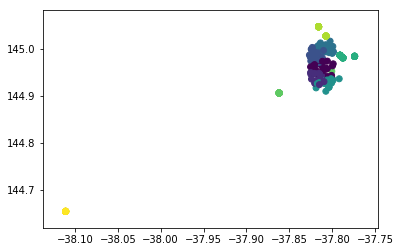

In [20]:
plt.scatter(df_dirty['Origin Latitude'], df_dirty['Origin Longitude'], marker = 'o', c = df_dirty['Origin Region'])

Difficult to say that if there is an error, but we will be using a knn approach with k=3 to see if any point is different from its neighbors. 

In [21]:
df_dirty['Origin Region'].value_counts()

6    41
8    39
3    37
9    36
2    32
5    29
4    29
7    27
1    26
Name: Origin Region, dtype: int64

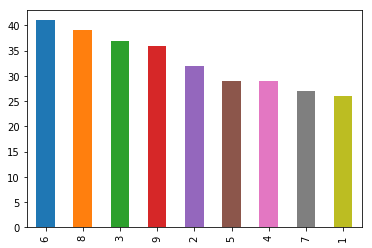

In [22]:
df_dirty['Origin Region'].value_counts().plot.bar()

In [23]:
# Create a knn object for classification
knn = KNeighborsClassifier(n_neighbors=3)
X = df_dirty[['Origin Latitude', 'Origin Longitude']]
y = df_dirty[['Origin Region']]
knn.fit(X, y)

C:\Users\Naveen Kaushik\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [24]:
df_dirty['orig_reg_pred'] = knn.predict(X)
df_dirty['orig_reg_pred'].value_counts()

6    43
8    39
9    37
5    35
3    34
2    30
4    28
7    25
1    25
Name: orig_reg_pred, dtype: int64

In [25]:
df_dirty[df_dirty['Origin Region'] != df_dirty['orig_reg_pred']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,orig_reg_pred
11,ID1720190848,0,7,9,-37.787433,144.980377,-38.110916,144.654173,47033.0,2018-03-24,23:44:41,11350.50,2:53:51,25.84,6
19,ID1891955795,0,7,9,-37.800402,144.951842,-38.110916,144.654173,43926.0,2018-01-04,07:17:15,10563.06,10:13:18,12.97,1
20,ID3202552870,1,2,5,-37.773845,144.983689,-37.804305,144.929010,7586.0,2018-07-07,03:09:45,1733.04,3:38:38,24.96,6
23,ID5286413190,2,4,1,-38.110916,144.654173,-37.809257,144.960791,43532.0,2018-04-18,05:18:04,10551.24,8:13:55,670.91,9
70,ID1751123526,0,1,5,-37.815221,144.945023,-37.815193,144.927550,2680.0,2018-02-19,20:05:59,652.38,20:16:51,7.35,2
100,ID1389089766,0,1,6,-37.813696,144.946111,-37.773803,144.983647,9114.0,2018-01-09,05:27:25,2810.40,6:14:15,13.66,2
124,ID3502585185,1,3,2,-37.821903,144.969011,-37.824932,144.949447,2077.0,2018-02-02,22:04:37,531.60,22:13:28,18.34,1
125,ID5339069256,2,1,6,-37.806217,144.941498,-37.773803,144.983647,9370.0,2018-06-15,21:28:19,2899.26,22:16:38,207.29,5
126,ID5950644890,2,2,1,-37.812962,144.931495,-37.801571,144.963125,4371.0,2018-02-06,16:14:06,1172.10,16:33:38,94.86,5
157,ID3445095136,1,3,2,-37.813141,144.973893,-37.816176,144.945295,3031.0,2018-04-01,08:18:37,689.28,8:30:06,12.02,1


We do see some points that are not having the region that they should have, so we change those values. 

In [26]:
df_dirty['Origin Region'] = np.where(df_dirty['Origin Region'] != df_dirty['orig_reg_pred'],
                                     df_dirty['orig_reg_pred'], df_dirty['Origin Region'])

In [27]:
#To check that the error is corrected.
df_dirty[df_dirty['Origin Region'] != df_dirty['orig_reg_pred']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,orig_reg_pred


In [28]:
df_dirty['Origin Region'].value_counts()

6    43
8    39
9    37
5    35
3    34
2    30
4    28
7    25
1    25
Name: Origin Region, dtype: int64

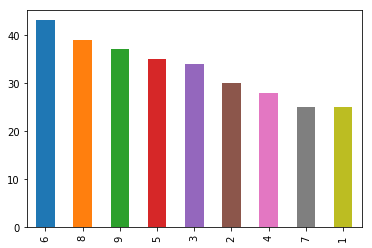

In [29]:
df_dirty['Origin Region'].value_counts().plot.bar()

If we notice, the distribution hasn't changed much but the values has shifted from one region to other. 

We do the same thing for Destination region as well as shown below.

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)
X = df_dirty[['Destination Latitude', 'Destination Longitude']]
y = df_dirty[['Destination Region']]
knn.fit(X, y)

C:\Users\Naveen Kaushik\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [31]:
df_dirty['dest_reg_pred'] = knn.predict(X)
df_dirty['dest_reg_pred'].value_counts()

4    38
2    38
1    37
7    36
8    34
5    32
9    30
3    27
6    24
Name: dest_reg_pred, dtype: int64

In [32]:
df_dirty[df_dirty['Destination Region'] != df_dirty['dest_reg_pred']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,orig_reg_pred,dest_reg_pred
4,ID5319568239,2,7,1,-37.861835,144.905716,-37.813678,144.939437,10194.1,2018-02-19,08:50:24,3359.88,9:46:23,217.54,7,2
13,ID5200136440,2,5,3,-37.800652,144.926986,-37.817329,145.008809,10006.0,2018-07-08,14:53:24,2544.84,15:35:48,183.27,5,4
28,ID3601644790,1,7,1,-37.861835,144.905716,-37.815239,144.975314,8485.0,2018-06-25,12:50:35,2936.52,13:39:31,23.13,7,3
35,ID3880801252,1,2,2,-37.813337,144.938456,-37.820017,144.978647,4359.0,2018-01-04,09:33:56,1011.90,9:50:47,9.01,2,3
39,ID5119562171,2,2,4,-37.822217,144.950109,-38.110916,144.654173,42178.0,2018-04-18,20:56:29,10132.26,23:45:21,638.55,2,9
40,ID1231123109,0,9,3,-38.110916,144.654173,-37.773845,144.983689,48197.0,2018-07-28,05:52:08,11495.34,9:03:43,26.93,9,6
90,ID1483643396,0,6,4,-37.787433,144.980377,-37.815153,145.006058,5266.0,2018-01-13,17:33:28,1354.80,17:56:02,13.09,6,3
91,ID3796502923,1,8,3,-37.807202,145.026637,-37.809673,144.992522,3641.0,2018-04-16,22:03:57,860.82,22:18:17,18.10,8,4
99,ID5472475847,2,5,4,-37.807331,144.909436,-37.807202,145.026637,11200.0,2018-07-28,10:37:12,3022.52,11:26:11,198.14,5,8
105,ID3706423641,1,6,1,-37.773845,144.983689,-37.812029,144.945175,6239.0,2018-07-01,02:14:04,1334.64,2:36:18,24.95,6,2


In [33]:
df_dirty['Destination Region'] = np.where(df_dirty['Destination Region'] != df_dirty['dest_reg_pred'],
                                     df_dirty['dest_reg_pred'], df_dirty['Destination Region'])

In [34]:
df_dirty[df_dirty['Destination Region'] != df_dirty['dest_reg_pred']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,orig_reg_pred,dest_reg_pred


In [35]:
df_dirty['Destination Region'].value_counts()

4    38
2    38
1    37
7    36
8    34
5    32
9    30
3    27
6    24
Name: Destination Region, dtype: int64

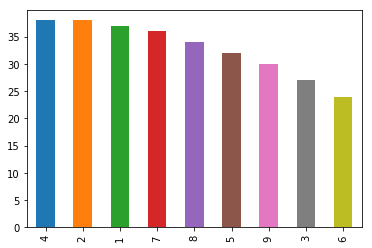

In [36]:
df_dirty['Destination Region'].value_counts().plot.bar()

We now drop the additional columns that we added. 

In [37]:
df_dirty.drop(['orig_reg_pred', 'dest_reg_pred'], 1, inplace=True)

### 3.4 Fix Departure date

Next, we look at the Departure date and see if there is anything funny there. 

Below code, tries to parse the date and see if there are any unparsable dates.

In [38]:
for i, row in df_dirty.iterrows():
    dt = row['Departure Date'].strip()
    try:
        parse(dt)
    except:
        print(dt)

2018-16-07
2018-27-03
2018-26-05
2018-28-04
2018-23-05
2018-27-02
2018-02-30
2018-06-31
2018-02-30
2018-04-31
2018-06-31
2018-06-31
2018-06-31
2018-04-31
2018-04-31
2018-02-30


We see that there are some errors here. Few dates have a month more than 12, but it looks like, they have got the month and the date exchanged, so we can fix them. 

The next type of error is where there is an non-existant date, for eg. '2018-04-31' or '2018-02-30'. So, 31st April and 30th Feb are impossible dates and hence we just increment them to the next days based on the error. 

In [39]:
for i, row in df_dirty.iterrows():
    dt = row['Departure Date'].strip()
    try:
        parse(dt) #Using the parse() function we see if the date is parsable or not.
    except:
#         print(dt)
        spl = dt.split('-')
        if int(spl[1]) > 12: # If the month is wrong, fix it.
            spl[1], spl[2] = spl[2], spl[1]
        else:
            if spl[1] == "02":
                spl[1] = "03"
                spl[2] = "0" + str(int(spl[2]) - 28) #Logic to handle additional days included in Feb month
            else:
                spl[1] = "0" + str(int(spl[1]) + 1)
                spl[2] = "01"
        dt = '-'.join(spl)
#         print(dt)
        df_dirty.loc[i, 'Departure Date'] = dt

In [40]:
# Check again to see of error exists
for i, row in df_dirty.iterrows():
    dt = row['Departure Date'].strip()
    try:
        parse(dt)
    except:
        print(dt)

Oh, looks like we fixed all of them so lets move on.

### 3.5 Fix the Journey Distance and Travel time

Now we need to fix the Journey distance we need to calculate the shortest distance using the nodes given in the `edges.csv` and `nodes.csv`. 

### 3.5.1 Dijkstra's Algorithm

Dijkstra's algorithm will be used to find the shortest distance between nodes.

In [41]:
df_edges = pd.read_csv('edges.csv')
df_edges.rename(columns={'Unnamed: 0':'edge'}, inplace=True)
print(df_edges.shape)
df_edges.head()

(42224, 6)


,edge,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


In [42]:
G = nx.from_pandas_edgelist(df_edges, 'u', 'v', ['distance(m)'])
G[711327755][711332946]

{'distance(m)': 58.0}

In [43]:
df_nodes = pd.read_csv('nodes.csv')
df_nodes.rename(columns={'Unnamed: 0':'node'}, inplace=True)
print(df_nodes.shape)
df_nodes.head()

(17117, 3)


,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


In [44]:
# We need to merge the latitude and longitudes with the nodes given in the nodes file. 
df_dirty = pd.merge(df_dirty, df_nodes, left_on=['Origin Latitude', 'Origin Longitude'], 
                  right_on=['lat', 'lon'], how='left')
df_dirty.rename(columns={'node':'origin_node'}, inplace=True)
df_dirty.drop(['lat', 'lon'], 1, inplace=True)

df_dirty = pd.merge(df_dirty, df_nodes, left_on=['Destination Latitude', 'Destination Longitude'], 
                  right_on=['lat', 'lon'], how='left')
df_dirty.rename(columns={'node':'destination_node'}, inplace=True)
df_dirty.drop(['lat', 'lon'], 1, inplace=True)

print(df_dirty.shape)
df_dirty.head()

(296, 16)


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,origin_node,destination_node
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76,248746926,2455254499
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15149.5,2018-02-11,07:42:29,4917.48,9:04:26,12.99,1889485053,1390575046
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50805.0,2018-06-21,05:17:26,13173.36,8:56:59,23.34,1390575046,5002706670
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43998.7,2018-06-22,08:52:10,10677.60,11:50:07,54.64,5002706670,777840087
4,ID5319568239,2,7,2,-37.861835,144.905716,-37.813678,144.939437,10194.1,2018-02-19,08:50:24,3359.88,9:46:23,217.54,1390575046,634785708


In [45]:
# Function to calculate the travel time for a given path.
def traveltime(path, edges):

    tt = 0
    for i in range(len(path)-1):
        tt = tt + (edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['speed(km/h)'].values[0] * 1000)

    return tt

In [46]:
# Assign columns for calculating distance and time
df_dirty['dijkstra_dist'] = 0.0
df_dirty['dist_diff'] = 0.0
df_dirty['dijkstra_time'] = 0.0
df_dirty['time_diff'] = 0.0
for i, row in df_dirty.iterrows():
    src = row['origin_node']
    des = row['destination_node']
    dist, path = nx.single_source_dijkstra(G,source=src, target=des, weight='distance(m)')
    tt = traveltime(path, df_edges)
    df_dirty.loc[i, 'dijkstra_dist'] = dist
    df_dirty.loc[i, 'dist_diff'] = dist - row['Journey Distance(m)']
    
    df_dirty.loc[i, 'dijkstra_time'] = tt
    df_dirty.loc[i, 'time_diff'] = round(tt - row['Travel Time(s)'])
#     print(dist)
df_dirty.head()

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,origin_node,destination_node,dijkstra_dist,dist_diff,dijkstra_time,time_diff
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76,248746926,2455254499,7527.0,0.0,1685.16,-0.0
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15149.5,2018-02-11,07:42:29,4917.48,9:04:26,12.99,1889485053,1390575046,15151.0,1.5,4917.48,0.0
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50805.0,2018-06-21,05:17:26,13173.36,8:56:59,23.34,1390575046,5002706670,50797.0,-8.0,13173.36,-0.0
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43998.7,2018-06-22,08:52:10,10677.60,11:50:07,54.64,5002706670,777840087,43999.0,0.3,10677.60,0.0
4,ID5319568239,2,7,2,-37.861835,144.905716,-37.813678,144.939437,10194.1,2018-02-19,08:50:24,3359.88,9:46:23,217.54,1390575046,634785708,10197.0,2.9,3359.88,0.0


#### 3.5.2 Fix Journey Distance

We see with the below code the anamolies in the distance. 

In [47]:
df_dirty['dist_diff'].value_counts()

 0.0    291
 0.3      1
 2.9      1
 1.8      1
-8.0      1
 1.5      1
Name: dist_diff, dtype: int64

We now replace the Journey distance with the corrected values for the rows which have errors. 

In [48]:
df_dirty['Journey Distance(m)'] = np.where(df_dirty['Journey Distance(m)'] != df_dirty['dijkstra_dist'],
                                     df_dirty['dijkstra_dist'], df_dirty['Journey Distance(m)'])

To recheck, we do not find any row which have distance errors.

In [49]:
df_dirty[df_dirty['Journey Distance(m)'] != df_dirty['dijkstra_dist']]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,origin_node,destination_node,dijkstra_dist,dist_diff,dijkstra_time,time_diff


In [50]:
df_dirty.head()

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,origin_node,destination_node,dijkstra_dist,dist_diff,dijkstra_time,time_diff
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76,248746926,2455254499,7527.0,0.0,1685.16,-0.0
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15151.0,2018-02-11,07:42:29,4917.48,9:04:26,12.99,1889485053,1390575046,15151.0,1.5,4917.48,0.0
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50797.0,2018-06-21,05:17:26,13173.36,8:56:59,23.34,1390575046,5002706670,50797.0,-8.0,13173.36,-0.0
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43999.0,2018-06-22,08:52:10,10677.60,11:50:07,54.64,5002706670,777840087,43999.0,0.3,10677.60,0.0
4,ID5319568239,2,7,2,-37.861835,144.905716,-37.813678,144.939437,10197.0,2018-02-19,08:50:24,3359.88,9:46:23,217.54,1390575046,634785708,10197.0,2.9,3359.88,0.0


#### 3.5.4 Fix Travel Time

Now from the above calculated time difference from the calculated time and the travel time given.

In [51]:
df_dirty['time_diff'].value_counts()

-0.0     277
 27.0      4
-24.0      2
 78.0      1
-2.0       1
 4.0       1
 40.0      1
-8.0       1
-68.0      1
-12.0      1
-83.0      1
-66.0      1
 2.0       1
-49.0      1
-23.0      1
 26.0      1
Name: time_diff, dtype: int64

Below rows have errors in the travel time. 

In [52]:
df_dirty[df_dirty['time_diff'] != 0]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,origin_node,destination_node,dijkstra_dist,dist_diff,dijkstra_time,time_diff
40,ID1231123109,0,9,6,-38.110916,144.654173,-37.773845,144.983689,48197.0,2018-07-28,05:52:08,11495.34,9:03:43,26.93,5002706670,2455254499,48197.0,0.0,11522.28,27.0
77,ID3675831001,1,3,1,-37.819752,144.985032,-37.819283,144.952701,3246.0,2018-06-09,02:15:17,737.14,2:28:00,22.25,54552187,4716795332,3246.0,0.0,763.14,26.0
80,ID3141775098,1,6,9,-37.790818,144.985793,-38.110916,144.654173,47186.0,2018-04-23,02:19:25,11442.06,5:29:43,70.68,4307007287,5002706670,47186.0,0.0,11418.06,-24.0
88,ID3624752369,1,8,1,-37.815834,145.046450,-37.818903,144.947178,9341.0,2018-05-12,21:37:40,2603.42,22:20:40,32.22,1889485053,92141618,9341.0,0.0,2580.42,-23.0
94,ID1730368172,0,9,2,-38.110916,144.654173,-37.815978,144.938301,42534.0,2018-04-14,16:23:02,10259.62,19:13:12,21.06,5002706670,1560149576,42534.0,0.0,10210.62,-49.0
96,ID3851833732,1,7,8,-37.861835,144.905716,-37.807202,145.026637,13986.0,2018-06-14,14:52:06,4316.40,16:03:38,30.60,1390575046,304700558,13986.0,0.0,4292.40,-24.0
97,ID1161461488,0,3,8,-37.824416,144.998682,-37.807202,145.026637,4383.0,2018-04-16,03:04:18,1055.82,3:21:53,11.06,343316059,304700558,4383.0,0.0,1058.04,2.0
98,ID3424773057,1,7,5,-37.861835,144.905716,-37.788259,144.929239,12611.0,2018-01-12,09:53:58,4041.90,11:00:13,23.47,1390575046,65702505,12611.0,0.0,3975.90,-66.0
99,ID5472475847,2,5,8,-37.807331,144.909436,-37.807202,145.026637,11200.0,2018-07-28,10:37:12,3022.52,11:26:11,198.14,4754129538,304700558,11200.0,0.0,2939.52,-83.0
100,ID1389089766,0,2,6,-37.813696,144.946111,-37.773803,144.983647,9114.0,2018-01-09,05:27:25,2810.40,6:14:15,13.66,2716423452,2455254505,9114.0,0.0,2837.34,27.0


Now, there is a possibility of having multiple shortest paths but the travel time could be different because of different speed limits on different roads. The below code checks that and it will print out the indices of the rows if it finds any such error. If there is nothing printed, it means that there are no such cases. 

In [53]:
# Check if there are other shortest paths which might give same travel time
for i, row in df_dirty[df_dirty['time_diff'] != 0].iterrows():
    src = row['origin_node']
    des = row['destination_node']
    paths = nx.all_shortest_paths(G,source=src, target=des, weight='weight')
    time_list = []
    for path in paths:
        time_list.append(round(traveltime(path, df_edges), 2))
    if row['Travel Time(s)'] in time_list:
        print(i, row['Travel Time(s)'], time_list)

Now we fix the travel time for the rows which have errors. 

In [54]:
df_dirty['Travel Time(s)'] = np.where(df_dirty['Travel Time(s)'] != df_dirty['dijkstra_time'],
                                     df_dirty['dijkstra_time'], df_dirty['Travel Time(s)'])

## 3.6 Fix Arrival time

There are two kinds of errors in the Arrival time. The first kind is where the Arrival and Departure are correct but they are interchanged. The second kind is where the adding the travel time to departure time does not add up to arrival time. 

First we convert the departure date and time to datetime format. 

In [55]:
df_dirty['Departure Time'] = pd.to_datetime(df_dirty['Departure Time'],format= '%H:%M:%S')
df_dirty['Arrival Time'] = pd.to_datetime(df_dirty['Arrival Time'],format= '%H:%M:%S')

In [56]:
df_dirty['Departure Time'].head()

0   1900-01-01 17:45:20
1   1900-01-01 07:42:29
2   1900-01-01 05:17:26
3   1900-01-01 08:52:10
4   1900-01-01 08:50:24
Name: Departure Time, dtype: datetime64[ns]

In [57]:
# Exchange departure and arrival time
count = 0
for i, row in df_dirty.iterrows():
    t_diff = (row['Arrival Time'] - row['Departure Time'])/ np.timedelta64(1, 's')

    if t_diff < 0:
        if (abs(t_diff) - row['Travel Time(s)']) < 0.01:  # The difference of 0.01 is taken to take care of rounding issue
            count += 1
            print("exchange", i, t_diff)
            df_dirty.loc[i, 'Departure Time'], df_dirty.loc[i, 'Arrival Time'] = \
                    df_dirty.loc[i, 'Arrival Time'], df_dirty.loc[i, 'Departure Time']
print(count)

exchange 145 -3120.0
exchange 146 -1237.0
exchange 147 -4007.0
exchange 149 -976.0
exchange 150 -1122.0
exchange 152 -3925.0
exchange 154 -1767.0
exchange 158 -638.0
exchange 159 -1816.0
exchange 162 -719.0
10


The above code shows the places where the Departure and Arrival needs to be exchanged. 

Now below we fix the second kind of issue. 

In [58]:
# Check if arrival != (departure + travel time)
count = 0
for i, row in df_dirty.iterrows():    
    arr_time = row['Departure Time'] + pd.Timedelta(seconds=round(row['Travel Time(s)']))
    arr_diff = arr_time - row['Arrival Time']
    if arr_diff.seconds > 1 and arr_diff.days != -1:
        df_dirty.loc[i, 'Arrival Time'] = arr_time
        print(i, row['Departure Time'], round(row['Travel Time(s)']), row['Arrival Time'], arr_time, arr_time - row['Arrival Time'])
        count += 1
print(count)

40 1900-01-01 05:52:08 11522 1900-01-01 09:03:43 1900-01-01 09:04:10 0 days 00:00:27
97 1900-01-01 03:04:18 1058 1900-01-01 03:21:53 1900-01-01 03:21:56 0 days 00:00:03
100 1900-01-01 05:27:25 2837 1900-01-01 06:14:15 1900-01-01 06:14:42 0 days 00:00:27
103 1900-01-01 03:05:44 12979 1900-01-01 06:41:36 1900-01-01 06:42:03 0 days 00:00:27
106 1900-01-01 15:22:39 896 1900-01-01 15:36:54 1900-01-01 15:37:35 0 days 00:00:41
108 1900-01-01 05:08:44 11719 1900-01-01 06:26:27 1900-01-01 08:24:03 0 days 01:57:36
119 1900-01-01 13:49:03 2118 1900-01-01 14:14:20 1900-01-01 14:24:21 0 days 00:10:01
123 1900-01-01 04:27:58 1709 1900-01-01 04:40:41 1900-01-01 04:56:27 0 days 00:15:46
194 1900-01-01 09:41:24 2014 1900-01-01 10:14:30 1900-01-01 10:14:58 0 days 00:00:28
243 1900-01-01 22:56:41 834 1900-01-01 23:09:17 1900-01-01 23:10:35 0 days 00:01:18
264 1900-01-01 12:07:27 1440 1900-01-01 12:31:00 1900-01-01 12:31:27 0 days 00:00:27
11


So the above code has fixed the second kind of errors as well. 

We see that there are extra columns that we added so we need to remove them. 

In [59]:
df_dirty.columns

Index(['Unnamed: 0', 'Uber Type', 'Origin Region', 'Destination Region',
       'Origin Latitude', 'Origin Longitude', 'Destination Latitude',
       'Destination Longitude', 'Journey Distance(m)', 'Departure Date',
       'Departure Time', 'Travel Time(s)', 'Arrival Time', 'Fare$',
       'origin_node', 'destination_node', 'dijkstra_dist', 'dist_diff',
       'dijkstra_time', 'time_diff'],
      dtype='object')

In [60]:
df_dirty.drop(['origin_node', 'destination_node', 'dijkstra_dist', 'dist_diff',\
               'dijkstra_time', 'time_diff'], 1, inplace=True)

Convert back the Departure time and Arrival time back to their original format of string. 

In [61]:
df_dirty['Departure Time'] = df_dirty['Departure Time'].dt.time
df_dirty['Arrival Time'] = df_dirty['Arrival Time'].dt.time

In [62]:
df_dirty.head()

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15151.0,2018-02-11,07:42:29,4917.48,09:04:26,12.99
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50797.0,2018-06-21,05:17:26,13173.36,08:56:59,23.34
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43999.0,2018-06-22,08:52:10,10677.60,11:50:07,54.64
4,ID5319568239,2,7,2,-37.861835,144.905716,-37.813678,144.939437,10197.0,2018-02-19,08:50:24,3359.88,09:46:23,217.54


In [63]:
print(df_dirty.shape)
df_dirty.columns

(296, 14)


Index(['Unnamed: 0', 'Uber Type', 'Origin Region', 'Destination Region',
       'Origin Latitude', 'Origin Longitude', 'Destination Latitude',
       'Destination Longitude', 'Journey Distance(m)', 'Departure Date',
       'Departure Time', 'Travel Time(s)', 'Arrival Time', 'Fare$'],
      dtype='object')

In [64]:
df_dirty.to_csv('29620163_dirty_data_solution.csv', index=False)

A copy of the cleaned data is created to create the model for predicting fare. 

In [65]:
df_dirty_model = df_dirty.copy()
print(df_dirty_model.shape)
df_dirty_model.head()

(296, 14)


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15151.0,2018-02-11,07:42:29,4917.48,09:04:26,12.99
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50797.0,2018-06-21,05:17:26,13173.36,08:56:59,23.34
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43999.0,2018-06-22,08:52:10,10677.60,11:50:07,54.64
4,ID5319568239,2,7,2,-37.861835,144.905716,-37.813678,144.939437,10197.0,2018-02-19,08:50:24,3359.88,09:46:23,217.54


## 3.7 Add weekday/weekend flag and time of day flag

In [66]:
# Function to get the weekday or weekend flag
def get_day_flag(dt):
    try:
        dt_obj = parse(dt)
        if dt_obj.weekday() >= 5:
            return 2
        else:
            return 1
    except:
        return 1

In [67]:
df_dirty_model['day_flag'] = df_dirty_model.apply(lambda row: get_day_flag(row['Departure Date']), axis=1)

In [68]:
df_dirty_model['day_flag'].head()

0    1
1    2
2    1
3    1
4    1
Name: day_flag, dtype: int64

In [69]:
# Function to get the time of the departure flag according to specification
def get_time_flag(tm):
    tm_obj = datetime.datetime.strptime(tm, "%H:%M:%S")
    ret = 0
    
    if datetime.datetime.strptime("6:00:00", "%H:%M:%S") <= tm_obj <= datetime.datetime.strptime("11:59:59", "%H:%M:%S"):
        ret = 0
    elif datetime.datetime.strptime("12:00:00", "%H:%M:%S") <= tm_obj <= datetime.datetime.strptime("20:59:59", "%H:%M:%S"):
        ret = 1
    else:
        ret = 2

    return ret

In [70]:
df_dirty_model['time_flag'] = df_dirty_model.apply(lambda row: get_time_flag(str(row['Departure Time'])), axis=1)

In [71]:
df_dirty_model['time_flag'].value_counts()

1    118
2    104
0     74
Name: time_flag, dtype: int64

In [72]:
df_dirty_model.head()

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,day_flag,time_flag
0,ID1183751897,0,3,6,-37.823856,144.998242,-37.773845,144.983689,7527.0,2018-02-23,17:45:20,1685.16,18:13:25,6.76,1,1
1,ID1860781662,0,8,7,-37.815834,145.046450,-37.861835,144.905716,15151.0,2018-02-11,07:42:29,4917.48,09:04:26,12.99,2,0
2,ID1859208106,0,7,9,-37.861835,144.905716,-38.110916,144.654173,50797.0,2018-06-21,05:17:26,13173.36,08:56:59,23.34,1,2
3,ID3596918891,1,9,1,-38.110916,144.654173,-37.801808,144.956876,43999.0,2018-06-22,08:52:10,10677.60,11:50:07,54.64,1,0
4,ID5319568239,2,7,2,-37.861835,144.905716,-37.813678,144.939437,10197.0,2018-02-19,08:50:24,3359.88,09:46:23,217.54,1,0


In [73]:
# Columns to use for training for model and Fare is the target
model_cols = ['Uber Type', 'Journey Distance(m)', 'day_flag', 'time_flag', 'Travel Time(s)', 'Fare$']

In [74]:
df_clean_model = df_dirty_model[model_cols]

## 4. Missing values 

In [75]:
df_missing = pd.read_csv('29620163_missing_value.csv')
print(df_missing.shape)
df_missing.head()

(85, 14)


,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID1691799860,0.0,7,6,-37.861835,144.905716,-37.790818,144.985793,11712.0,2018-02-23,04:35:37,3700.98,5:37:17,17.08
1,ID3361990342,NaN,4,7,-37.802382,144.991462,-37.861835,144.905716,11014.0,2018-04-20,01:06:28,3651.90,2:07:19,27.56
2,ID1390438935,0.0,1,4,-37.814123,144.944413,-37.800987,144.992572,5083.0,2018-06-21,18:24:11,1326.18,18:46:17,8.92
3,ID1518876793,NaN,8,4,-37.815834,145.046450,-37.807842,145.013209,3948.0,2018-06-12,16:39:04,1278.36,17:00:22,8.24
4,ID1156908651,0.0,6,4,-37.773803,144.983647,-37.798905,145.011509,10323.0,2018-01-15,19:39:35,3181.20,20:32:36,13.74


In [76]:
df_missing.describe()

,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,67.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,69.000000
mean,0.671642,5.352941,5.000000,-37.860155,144.924427,-37.842664,144.939241,17442.717647,4567.517647,63.245652
std,0.725886,2.675755,2.468854,0.109046,0.122630,0.089677,0.101106,17323.180932,4173.201548,167.229053
min,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,2043.000000,478.080000,4.640000
25%,0.000000,3.000000,3.000000,-37.861835,144.905716,-37.825050,144.928569,5296.000000,1379.820000,13.080000
50%,1.000000,6.000000,5.000000,-37.815834,144.956355,-37.812378,144.963768,10030.000000,3137.700000,19.180000
75%,1.000000,8.000000,7.000000,-37.807233,144.997068,-37.803277,145.000589,15151.000000,4917.480000,31.760000
max,2.000000,9.000000,9.000000,-37.773803,145.046450,-37.773803,145.046450,51032.000000,13204.980000,1046.990000


In [77]:
for col in df_missing.columns:
    if np.any(df_missing[col].isna()):
        print(col)

Uber Type
Fare$


We see from the above code that Uber type and Fare is missing. 

The below code works on the same logic as earlier and uses the previously created function. 

In [78]:
for i, row in df_missing.iterrows():
    if np.isnan(row['Uber Type']):
        df_missing.loc[i, 'Uber Type'] = get_uber_type(str(row['Unnamed: 0'])[0:3])

In [79]:
df_missing.describe()

,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,69.000000
mean,0.647059,5.352941,5.000000,-37.860155,144.924427,-37.842664,144.939241,17442.717647,4567.517647,63.245652
std,0.702138,2.675755,2.468854,0.109046,0.122630,0.089677,0.101106,17323.180932,4173.201548,167.229053
min,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,2043.000000,478.080000,4.640000
25%,0.000000,3.000000,3.000000,-37.861835,144.905716,-37.825050,144.928569,5296.000000,1379.820000,13.080000
50%,1.000000,6.000000,5.000000,-37.815834,144.956355,-37.812378,144.963768,10030.000000,3137.700000,19.180000
75%,1.000000,8.000000,7.000000,-37.807233,144.997068,-37.803277,145.000589,15151.000000,4917.480000,31.760000
max,2.000000,9.000000,9.000000,-37.773803,145.046450,-37.773803,145.046450,51032.000000,13204.980000,1046.990000


In [80]:
df_missing['Uber Type'].value_counts()

0.0    41
1.0    33
2.0    11
Name: Uber Type, dtype: int64

Create the day and time flag from the previously created function. 

In [81]:
df_missing['day_flag'] = df_missing.apply(lambda row: get_day_flag(row['Departure Date']), axis=1)
df_missing['time_flag'] = df_missing.apply(lambda row: get_time_flag(row['Departure Time']), axis=1)

In [82]:
df_missing_model = df_missing[model_cols].dropna()
print(df_missing_model.shape)
df_missing_model.head()

(69, 6)


,Uber Type,Journey Distance(m),day_flag,time_flag,Travel Time(s),Fare$
0,0.0,11712.0,1,2,3700.98,17.08
1,1.0,11014.0,1,2,3651.90,27.56
2,0.0,5083.0,1,1,1326.18,8.92
3,0.0,3948.0,1,1,1278.36,8.24
4,0.0,10323.0,1,1,3181.20,13.74


In [83]:
df_clean_model['Uber Type'].value_counts()

0    148
1    108
2     40
Name: Uber Type, dtype: int64

In [84]:
df_model_full = pd.concat([df_missing_model, df_clean_model], ignore_index=True)
print(df_model_full.shape)
df_model_full.head()

(365, 6)


,Uber Type,Journey Distance(m),day_flag,time_flag,Travel Time(s),Fare$
0,0.0,11712.0,1,2,3700.98,17.08
1,1.0,11014.0,1,2,3651.90,27.56
2,0.0,5083.0,1,1,1326.18,8.92
3,0.0,3948.0,1,1,1278.36,8.24
4,0.0,10323.0,1,1,3181.20,13.74


The above code joins the cleaned data and the data from missing file which has correct fare. 

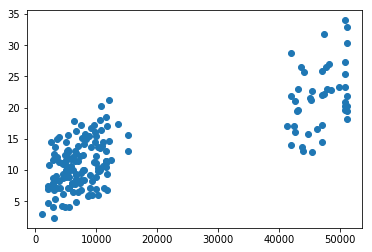

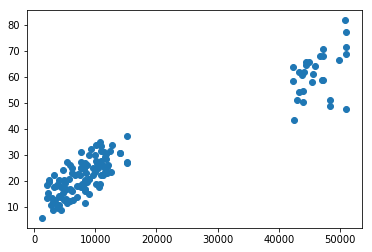

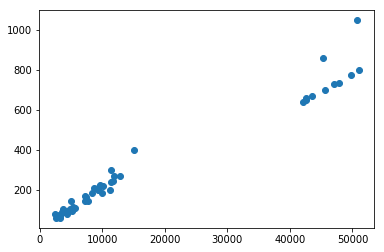

In [85]:
for utype in [0, 1, 2]:
    temp_df = df_model_full[df_model_full['Uber Type'] == utype]
    plt.scatter(temp_df['Journey Distance(m)'], temp_df['Fare$'])
    plt.show()

In [86]:
# Below function creates the model for the data frame passed.
def build_model(df):
    X = [t for t in model_cols if t != 'Fare$']
    fit = LinearRegression().fit(df[X].values,
                                     df['Fare$'].values.reshape(-1, 1))
    pred = fit.predict(df[X].values)
    print("R-squared value is ",r2_score(df['Fare$'], pred))
    plt.scatter(df['Fare$'], pred)
    plt.show()
    return fit

The below 3 cells creates the model per Uber Type. Since the fare varies a lot per Uber Type, it makes sense to create a model separately. 

R-squared value is  0.8935110224522336


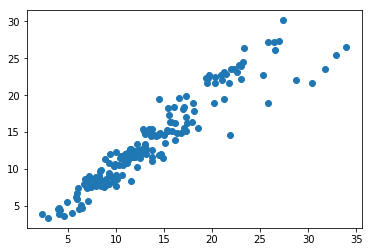

In [87]:
temp_df = df_model_full[df_model_full['Uber Type'] == 0]
model_utype_0 = build_model(temp_df)

R-squared value is  0.9675167919767146


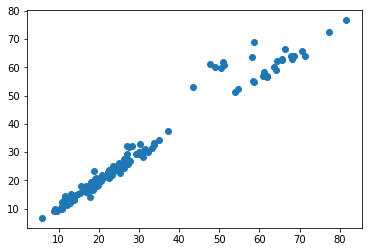

In [88]:
temp_df = df_model_full[df_model_full['Uber Type'] == 1]
model_utype_1 = build_model(temp_df)

R-squared value is  0.9804238971695953


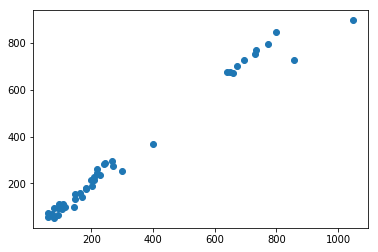

In [89]:
temp_df = df_model_full[df_model_full['Uber Type'] == 2]
model_utype_2 = build_model(temp_df)

In [90]:
print(model_utype_0.coef_)
print(model_utype_1.coef_)
print(model_utype_2.coef_)

[[ 0.00000000e+00 -2.02563213e-04  3.62240629e+00  3.78269528e+00
   1.98196107e-03]]
[[ 0.00000000e+00 -5.71637829e-05  2.97057586e+00  5.10239635e+00
   4.62660867e-03]]
[[ 0.00000000e+00 -4.87904672e-03 -4.32041669e+00 -5.91399666e+00
   8.55609114e-02]]


Now, we do the prediction for missing fare and impute the values.

In [91]:
# The loop checks the Uber Type and predicts based on the appropriate models.
for i, row in df_missing.iterrows():
    if np.isnan(row['Fare$']):
        utype = row['Uber Type']
        if utype == 0:
            X_var = [t for t in model_cols if t != 'Fare$']
            pred_fare = model_utype_0.predict([row[X_var]])[0]
        elif utype == 1:
            X_var = [t for t in model_cols if t != 'Fare$']
            pred_fare = model_utype_1.predict([row[X_var]])[0]
        elif utype == 2:
            X_var = [t for t in model_cols if t != 'Fare$']
            pred_fare = model_utype_2.predict([row[X_var]])[0]
            
        df_missing.loc[i, 'Fare$'] = pred_fare
            

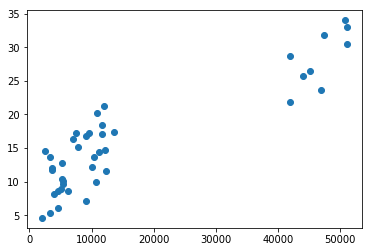

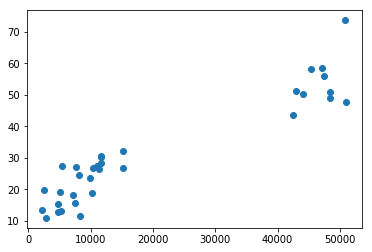

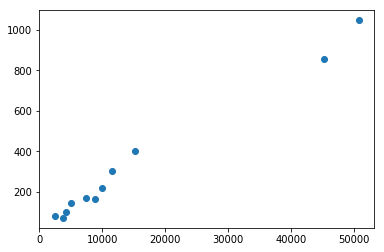

In [92]:
for utype in [0, 1, 2]:
    temp_df = df_missing[df_missing['Uber Type'] == utype]
    plt.scatter(temp_df['Journey Distance(m)'], temp_df['Fare$'])
    plt.show()

Drop the additional columns added.

In [93]:
df_missing.drop(['day_flag', 'time_flag'], 1, inplace=True)

In [94]:
print(df_missing.shape)
df_missing.columns

(85, 14)


Index(['Unnamed: 0', 'Uber Type', 'Origin Region', 'Destination Region',
       'Origin Latitude', 'Origin Longitude', 'Destination Latitude',
       'Destination Longitude', 'Journey Distance(m)', 'Departure Date',
       'Departure Time', 'Travel Time(s)', 'Arrival Time', 'Fare$'],
      dtype='object')

In [95]:
#Write to Output file
df_missing.to_csv('29620163_missing_value_solution.csv', index=False)

## 5. Outlier data

In [96]:
df_outliers = pd.read_csv('29620163_outliers.csv')
print(df_outliers.shape)
df_outliers.head()

(127, 15)


,Unnamed: 0,Unnamed: 0.1,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,0,ID1831470684,0,3,8,-37.818022,144.993896,-37.807202,145.026637,4158.0,2018-03-21,05:32:10,1011.54,5:49:01,13.79
1,1,ID3540918375,1,5,7,-37.799659,144.924813,-37.861835,144.905716,11915.0,2018-01-28,10:31:23,3744.30,11:33:47,27.44
2,2,ID1688563609,0,3,6,-37.815974,144.972464,-37.773845,144.983689,5019.0,2018-04-24,03:17:00,1056.42,3:34:36,15.84
3,3,ID3902803159,1,8,2,-37.807202,145.026637,-37.818716,144.916805,10709.0,2018-07-09,09:25:42,2756.34,10:11:38,18.74
4,4,ID1320405756,0,4,6,-37.801751,144.995098,-37.773845,144.983689,5668.0,2018-07-04,13:57:29,1169.94,14:16:58,8.98


In [97]:
df_outliers['Uber Type'].value_counts()

0    62
1    49
2    16
Name: Uber Type, dtype: int64

In [98]:
df_outliers['fare_predicted'] = 0

In [99]:
df_outliers['day_flag'] = df_outliers.apply(lambda row: get_day_flag(row['Departure Date']), axis=1)
df_outliers['time_flag'] = df_outliers.apply(lambda row: get_time_flag(row['Departure Time']), axis=1)

In [100]:
# Calculate the predicted fare for all the outliers data
for i, row in df_outliers.iterrows():
    utype = row['Uber Type']
    X_var = [t for t in model_cols if t != 'Fare$']
    if utype == 0:
        pred_fare = model_utype_0.predict([row[X_var]])[0]
    elif utype == 1:
        pred_fare = model_utype_1.predict([row[X_var]])[0]
    elif utype == 2:
        pred_fare = model_utype_2.predict([row[X_var]])[0]

    df_outliers.loc[i, 'fare_predicted'] = pred_fare

In [101]:
df_outliers.head()

,Unnamed: 0,Unnamed: 0.1,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,fare_predicted,day_flag,time_flag
0,0,ID1831470684,0,3,8,-37.818022,144.993896,-37.807202,145.026637,4158.0,2018-03-21,05:32:10,1011.54,5:49:01,13.79,11.798931,1,2
1,1,ID3540918375,1,5,7,-37.799659,144.924813,-37.861835,144.905716,11915.0,2018-01-28,10:31:23,3744.30,11:33:47,27.44,24.926543,2,0
2,2,ID1688563609,0,3,6,-37.815974,144.972464,-37.773845,144.983689,5019.0,2018-04-24,03:17:00,1056.42,3:34:36,15.84,11.713475,1,2
3,3,ID3902803159,1,8,2,-37.807202,145.026637,-37.818716,144.916805,10709.0,2018-07-09,09:25:42,2756.34,10:11:38,18.74,17.454002,1,0
4,4,ID1320405756,0,4,6,-37.801751,144.995098,-37.773845,144.983689,5668.0,2018-07-04,13:57:29,1169.94,14:16:58,8.98,8.024308,1,1


Now we calculate the residuals of the outliers data.

In [102]:
df_outliers['fare_diff'] = df_outliers['Fare$'] - df_outliers['fare_predicted']

In [103]:
for utype in [0, 1, 2]:
    temp_df = df_outliers[df_outliers['Uber Type'] == utype]
    print(r2_score(temp_df['Fare$'], temp_df['fare_predicted']))

0.6231895433766516
0.9268175646735856
0.7266283301668705


We create a copy of the of the cleaned data and predict the fare of those using the models previously fitted.

In [104]:
df_model_full_copy = df_model_full.copy()

In [105]:
df_model_full_copy['fare_predicted'] = 0

In [106]:
for i, row in df_model_full_copy.iterrows():
    utype = row['Uber Type']
    if utype == 0:
        X_var = [t for t in model_cols if t != 'Fare$']
        pred_fare = model_utype_0.predict([row[X_var]])[0]
    elif utype == 1:
        X_var = [t for t in model_cols if t != 'Fare$']
        pred_fare = model_utype_1.predict([row[X_var]])[0]
    elif utype == 2:
        X_var = [t for t in model_cols if t != 'Fare$']
        pred_fare = model_utype_2.predict([row[X_var]])[0]

    df_model_full_copy.loc[i, 'fare_predicted'] = pred_fare

In [107]:
# Calculate the residual of the data
df_model_full_copy['fare_diff'] = df_model_full_copy['Fare$'] - df_model_full_copy['fare_predicted']

In [108]:
df_model_full_copy.head()

,Uber Type,Journey Distance(m),day_flag,time_flag,Travel Time(s),Fare$,fare_predicted,fare_diff
0,0.0,11712.0,1,2,3700.98,17.08,15.599134,1.480866
1,1.0,11014.0,1,2,3651.90,27.56,31.784765,-4.224765
2,0.0,5083.0,1,1,1326.18,8.92,8.452469,0.467531
3,0.0,3948.0,1,1,1278.36,8.24,8.587601,-0.347601
4,0.0,10323.0,1,1,3181.20,13.74,11.067615,2.672385


Now we combine the residuals of the clean and the outlier data. 

In [109]:
df_res = pd.concat([df_model_full_copy[['fare_diff', 'Uber Type']], df_outliers[['fare_diff', 'Uber Type']]])
print(df_res.shape)
df_res.head()

(492, 2)


,fare_diff,Uber Type
0,1.480866,0.0
1,-4.224765,1.0
2,0.467531,0.0
3,-0.347601,0.0
4,2.672385,0.0


Boxplot per Uber type to visually see the residuals.

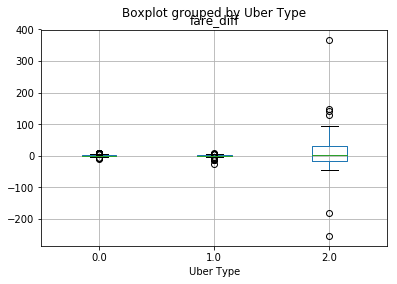

In [110]:
df_res.boxplot(column='fare_diff', by='Uber Type')

Now, in the following loop we iterate over each Uber type and calculate the First and the 3rd Qartile. Then we find the InterQuartile range. The upper and lower bound are calculated as:

lval = q1 - 1.5*iqr

uval = q3 + 1.5*iqr

For the Outliers data, we remove the data which is outside of these bounds per Uber type.

In [111]:
for utype in [0, 1, 2]:
    print("Uber type: ", utype)
    df = df_res[df_res['Uber Type'] == utype]
    df_o = df_outliers[df_outliers['Uber Type'] == utype]
    q1 = df['fare_diff'].quantile(0.25)
    q3 = df['fare_diff'].quantile(0.75)
    iqr = q3 - q1
#     print(q1, q3, iqr)
    lval = q1 - 1.5*iqr
    uval = q3 + 1.5*iqr
    print(lval, uval)
#     print("number of outliers in total: ", df[(df['fare_diff'] < lval) | (df['fare_diff'] > uval)].shape)
    print("number of outliers in Outlier file: ", df_o[(df_o['fare_diff'] < lval) | (df_o['fare_diff'] > uval)].shape)
    ind = df_outliers[(df_outliers['Uber Type'] == utype) &\
             ((df_outliers['fare_diff'] < lval) | (df_outliers['fare_diff'] > uval))].index
    df_outliers = df_outliers.loc[~df_outliers.index.isin(ind)]
#     print(ind)

Uber type:  0
-5.5417288782953165 6.4700952522399575
number of outliers in Outlier file:  (16, 19)
Uber type:  1
-4.451794246379778 4.695736664087249
number of outliers in Outlier file:  (5, 19)
Uber type:  2
-86.92134645038122 101.81576541979976
number of outliers in Outlier file:  (4, 19)


In [112]:
df_outliers.shape

(102, 19)

In [113]:
df_outliers.head()

,Unnamed: 0,Unnamed: 0.1,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,fare_predicted,day_flag,time_flag,fare_diff
0,0,ID1831470684,0,3,8,-37.818022,144.993896,-37.807202,145.026637,4158.0,2018-03-21,05:32:10,1011.54,5:49:01,13.79,11.798931,1,2,1.991069
1,1,ID3540918375,1,5,7,-37.799659,144.924813,-37.861835,144.905716,11915.0,2018-01-28,10:31:23,3744.30,11:33:47,27.44,24.926543,2,0,2.513457
2,2,ID1688563609,0,3,6,-37.815974,144.972464,-37.773845,144.983689,5019.0,2018-04-24,03:17:00,1056.42,3:34:36,15.84,11.713475,1,2,4.126525
3,3,ID3902803159,1,8,2,-37.807202,145.026637,-37.818716,144.916805,10709.0,2018-07-09,09:25:42,2756.34,10:11:38,18.74,17.454002,1,0,1.285998
4,4,ID1320405756,0,4,6,-37.801751,144.995098,-37.773845,144.983689,5668.0,2018-07-04,13:57:29,1169.94,14:16:58,8.98,8.024308,1,1,0.955692


In [114]:
df_outliers.drop(['fare_predicted', 'day_flag', 'time_flag', 'fare_diff'], 1, inplace=True)

In [115]:
print(df_outliers.shape)
df_outliers.columns

(102, 15)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Uber Type', 'Origin Region',
       'Destination Region', 'Origin Latitude', 'Origin Longitude',
       'Destination Latitude', 'Destination Longitude', 'Journey Distance(m)',
       'Departure Date', 'Departure Time', 'Travel Time(s)', 'Arrival Time',
       'Fare$'],
      dtype='object')

In [116]:
#Write to Output file
df_outliers.to_csv('29620163_outliers_solution.csv', index=False)

## 6. Summary

The necessary output files have been generated after fixing the errors present in them. 

* The dirty data file had a lot of erroneous values. Best efforts have been put into fixing them. 
* Missing data had missing values in Uber type and Fare which have been imputed.
* Outlier data had outliers in the fare and they have been dropped from the original data as correcting an outlier is not a wise thing to do. 

## 7. Observations

* In calculation of shortest path, there were multiple shortest path and the time varied from one path to other because of different speed limits on the roads. 
* In correcting the origin and destination region, there were some data points which had overlaps and could be a part of any region. 

## 8. References
- Monash Moodle for FIT5196 https://lms.monash.edu/course/view.php?id=50799
- Select Pandas rows based on list index https://stackoverflow.com/questions/19155718/select-pandas-rows-based-on-list-index
- Boxplots in matplotlib: Markers and outliers https://stackoverflow.com/questions/17725927/boxplots-in-matplotlib-markers-and-outliers
- how to use pandas filter with IQR? https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr
- How do I remove an element from a list by index in Python? https://stackoverflow.com/questions/627435/how-do-i-remove-an-element-from-a-list-by-index-in-python
- Python/Pandas convert string to time only https://stackoverflow.com/questions/37801321/python-pandas-convert-string-to-time-only
